In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-20 23:04:45.863467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 23:04:45.863534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 23:04:45.864679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 23:04:45.873182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 23:04:46.810892: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:50]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)']

input_features_xyz = ['X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

ew_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
# ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes,
#                                       non_transform_features=['Eccentricity',
#                                                               'Semimajor Axis (m)',
#                                                               'Inclination (deg)',
#                                                               'RAAN (deg)',
#                                                               #'Argument of Periapsis (deg)',
#                                                               #'True Anomaly (deg)',
#                                                               #'Longitude (deg)', # ?????????
#                                                               'Latitude (deg)'],
#                                       diff_transform_features=['True Anomaly (deg)'],
#                                       sin_transform_features=[],#['Longitude (deg)', 'Argument of Periapsis (deg)', 'RAAN (deg)'],
#                                       sin_cos_transform_features=['Longitude (deg)', 'Argument of Periapsis (deg)'],#['True Anomaly (deg)'],
#                                       add_daytime_feature=False,
#                                       add_yeartime_feature=False,
#                                       with_labels=True,
#                                       pad_location_labels=0,
#                                       nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
#                                       train_val_split=0.8,
#                                       input_stride=2,
#                                       padding='none',
#                                       scale=True,
#                                       per_object_scaling=False,
#                                       node_class_multipliers={'ID':1.0,'IK':1.0,'AD':1.0,'SS':1.0},
#                                       input_history_steps=48,
#                                       input_future_steps=24,
#                                       seed=181,
#                                       deepcopy=True,
#                                       input_dtype=np.float32,
#                                       verbose=2)

ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              'Latitude (deg)'],
                                      diff_transform_features=['True Anomaly (deg)'],
                                      sin_transform_features=['Longitude (deg)',
                                                               'Argument of Periapsis (deg)'],
                                      sin_cos_transform_features=[],
                                      overview_features_mean=['Longitude (sin)', 'RAAN (deg)'],
                                      overview_features_std=['Latitude (deg)'],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=True,
                                      with_labels=True,
                                      pad_location_labels=0,
                                      nonbinary_padding=[110.0, 70.0, 49.0, 34.0, 24.0],
                                      train_val_split=0.8,
                                      input_stride=8,
                                      padding='zero', #!
                                      scale=True,
                                      per_object_scaling=False,
                                      node_class_multipliers={'ID':1.5,'IK':1.0,'AD':1.0,'SS':1.0},
                                      input_history_steps=256,
                                      input_future_steps=256,
                                      seed=181,
                                      deepcopy=True,
                                      input_dtype=np.float32,
                                      verbose=2)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 256-256 @ stride 8
Scaling: True  
Node Class Multipliers: {'ID': 1.5, 'IK': 1.0, 'AD': 1.0, 'SS': 1.0}
Sin-Transforming features: ['Longitude (deg)', 'Argument of Periapsis (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['True Anomaly (deg)']
Wraparound offset for ft True Anomaly (deg): [270, -90]
Adding linear timeindex.
Scaling now.
Adding nb padding now.
Padding node locations in non-binary fashion ([24.0, 34.0, 49.0, 70.0, 110.0, 70.0, 49.0, 34.0, 24.0])
Fitting Labelencoders now.
Dropping 11 unused columns now.
Final 12 input features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (sin)', 'Argument of Periapsis (sin)', 'True Anomaly (deg) (diff)', 'LinearTimeIndex'] + overview of ['Longitude (sin)', 'RAAN (deg)'] (std) and ['Latitude (deg)'] (std)
=========================

In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-02-18 20:54:39.695727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 20:54:39.720695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 20:54:39.720773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 20:54:39.722855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 20:54:39.722936: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(655805, shape=(), dtype=int64)
(TensorSpec(shape=(None, 36, 10), dtype=tf.float32, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 10)]          0         
                                                                 
 conv1d (Conv1D)             (None, 31, 48)            2928      
                                                                 
 batch_normalization (Batch  (None, 31, 48)            192       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 31, 48)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)        

2024-02-18 20:54:53.338605: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-18 20:54:55.236238: I external/local_xla/xla/service/service.cc:168] XLA service 0x53881030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 20:54:55.236285: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-18 20:54:55.242091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708286095.343506  117558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


641/641 [==============================] - ETA: 0s - loss: 26.9478 - mse: 26.8371 - mae: 1.0762
Epoch 1: val_loss improved from inf to 18.78502, saving model to best_model.hdf5
641/641 [==============================] - 30s 31ms/step - loss: 26.9478 - mse: 26.8371 - mae: 1.0762 - val_loss: 18.7850 - val_mse: 18.6492 - val_mae: 0.7334
Epoch 2/80
641/641 [==============================] - ETA: 0s - loss: 17.5369 - mse: 17.3752 - mae: 0.7771
Epoch 2: val_loss improved from 18.78502 to 16.13783, saving model to best_model.hdf5
641/641 [==============================] - 17s 25ms/step - loss: 17.5369 - mse: 17.3752 - mae: 0.7771 - val_loss: 16.1378 - val_mse: 15.9506 - val_mae: 0.6783
Epoch 3/80
639/641 [============================>.] - ETA: 0s - loss: 15.5281 - mse: 15.3170 - mae: 0.6891
Epoch 3: val_loss improved from 16.13783 to 14.59333, saving model to best_model.hdf5
641/641 [==============================] - 17s 25ms/step - loss: 15.5223 - mse: 15.3111 - mae: 0.6891 - val_loss: 14.59

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


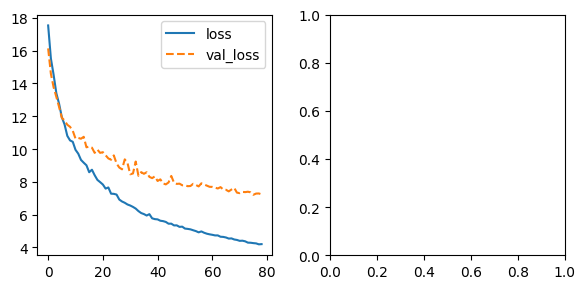

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(1024,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN(val_ew,
                                        conv1d_layers=[[48,6],[64,6],[48,6]], 
                                        dense_layers=[64,32],
                                        l2_reg=0.00025,
                                        mixed_batchnorm=True,
                                        mixed_dropout_dense=0.0,
                                        mixed_dropout_cnn=0.0,
                                        lr_scheduler=[0.003,2500,0.9],
                                        output_type='regression',
                                        final_activation='linear',
                                        seed=0)

model_ew.summary()
hist = model_ew.fit(train_ew,
                    val_ds=val_ew,
                    epochs=80,
                    early_stopping=15,
                    target_metric='val_loss',
                    save_best_only=True,
                    verbose=1,
                    plot_hist=True,
                    callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          with_identifier=True,
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
labels = np.stack([element for element in val_ns.map(lambda x,y,z:x).as_numpy_iterator()])
print(labels.shape)

In [ ]:
print(labels[:10,3,:])

In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
print(train_ns.element_spec)

model_ns = prediction_models.STATEFUL_LSTM(train_ns, val_ns,
                                            dense_layers=[32,16],
                                            lstm_layers=[48,48],
                                            l2_reg=0.000,
                                            mixed_dropout_dense=0.25,
                                            mixed_dropout_lstm=0.25,
                                            lr_scheduler=[0.003,7500,0.9],
                                            seed=0)

model_ns.summary()

In [ ]:

hist = model_ns.fit(train_ns, val_ds=val_ns,
                    epochs=2,
                    eval_frequency=2,
                    verbose=1,
                    plot_hist=False)

In [6]:
train_ns, val_ns = ds_gen_ns.get_datasets(1024,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ns.element_spec)

2024-02-20 23:21:22.472032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 23:21:22.493149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 23:21:22.493222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 23:21:22.494904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 23:21:22.494992: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(673830, shape=(), dtype=int64)
(TensorSpec(shape=(None, 64, 12), dtype=tf.float32, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 12)]          0         
                                                                 
 conv1d_78 (Conv1D)          (None, 59, 48)            3504      
                                                                 
 batch_normalization_78 (Ba  (None, 59, 48)            192       
 tchNormalization)                                               
                                                                 
 activation_130 (Activation  (None, 59, 48)            0         
 )                                                               
                                                                 
 dropout_130 (Dropout)       (None, 59, 48)            0         
                                                                 
 conv1d_79 (Conv1D)          (None, 54, 48)            138

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


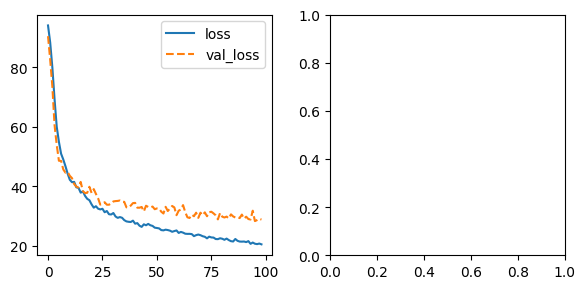

In [33]:
utils.set_random_seed(42)

model_ns = prediction_models.Dense_NN(val_ns,
                                        conv1d_layers=[[48,6],[48,6],[48,6]], # TODO test smaller kernels
                                        dense_layers=[64,32],
                                        l2_reg=0.00025,
                                        mixed_batchnorm=True,
                                        mixed_dropout_dense=0.05,
                                        mixed_dropout_cnn=0.1,
                                        lr_scheduler=[0.005,7000,0.9],
                                        output_type='regression',
                                        final_activation='linear',
                                        asymmetric_loss=-0.01, # value<0 to penalize underestimation more
                                        seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns,
                    val_ds=val_ns,
                    epochs=100,
                    verbose=1,
                    plot_hist=True,
                    early_stopping=15,
                    target_metric='val_loss',
                    save_best_only=True,
                    callbacks=[])
#23 35
# 25min for 100 epochs

In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_loss"
Epoch 1/50


659/659 [==============================] - 54s 80ms/step - loss: 17.0545 - mse: 14.8203 - mae: 0.4950 - val_loss: 34.0023 - val_mse: 31.7695 - val_mae: 0.6099
Epoch 2/50
659/659 [==============================] - 46s 68ms/step - loss: 16.6806 - mse: 14.4488 - mae: 0.4862 - val_loss: 34.2078 - val_mse: 31.9776 - val_mae: 0.6367
Epoch 3/50
659/659 [==============================] - 45s 67ms/step - loss: 17.1550 - mse: 14.9257 - mae: 0.4929 - val_loss: 34.2345 - val_mse: 32.0065 - val_mae: 0.6232
Epoch 4/50
659/659 [==============================] - 45s 67ms/step - loss: 16.6764 - mse: 14.4495 - mae: 0.4872 - val_loss: 35.1967 - val_mse: 32.9703 - val_mae: 0.6364
Epoch 5/50
659/659 [==============================] - 47s 70ms/step - loss: 16.4849 - mse: 14.2601 - mae: 0.4838 - val_loss: 34.5600 - val_mse: 32.3363 - val_mae: 0.6427
Epoch 6/50
659/659 [==============================] - 46s 68ms/step - loss: 16.7035 - mse: 14.4815 - mae: 0.4881 - val_loss: 33.6164 - val_mse: 31.3959 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


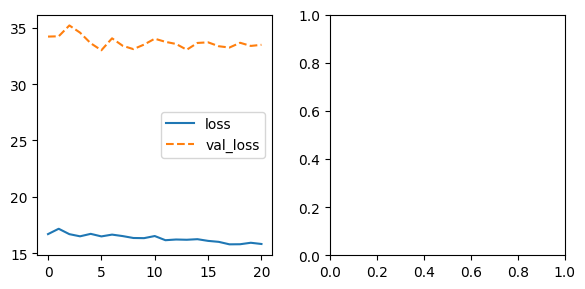

In [9]:
hist = model_ns.fit(train_ns,
                    val_ds=val_ns,
                    epochs=50,
                    verbose=1,
                    plot_hist=True,
                    early_stopping=15,
                    target_metric='val_loss',
                    callbacks=[])

Starting training. Optimizing "val_loss"
Epoch 1/50


641/641 [==============================] - ETA: 0s - loss: 3.4016 - mse: 2.7507 - mae: 0.1570
Epoch 1: val_loss improved from inf to 6.76846, saving model to best_model.hdf5
641/641 [==============================] - 18s 26ms/step - loss: 3.4016 - mse: 2.7507 - mae: 0.1570 - val_loss: 6.7685 - val_mse: 6.1177 - val_mae: 0.2297
Epoch 2/50
639/641 [============================>.] - ETA: 0s - loss: 3.3910 - mse: 2.7405 - mae: 0.1545
Epoch 2: val_loss improved from 6.76846 to 6.73232, saving model to best_model.hdf5
641/641 [==============================] - 18s 25ms/step - loss: 3.3953 - mse: 2.7448 - mae: 0.1546 - val_loss: 6.7323 - val_mse: 6.0820 - val_mae: 0.2629
Epoch 3/50
640/641 [============================>.] - ETA: 0s - loss: 3.3926 - mse: 2.7425 - mae: 0.1569
Epoch 3: val_loss did not improve from 6.73232
641/641 [==============================] - 17s 25ms/step - loss: 3.3907 - mse: 2.7406 - mae: 0.1568 - val_loss: 6.8026 - val_mse: 6.1527 - val_mae: 0.2177
Epoch 4/50
640/641 [

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


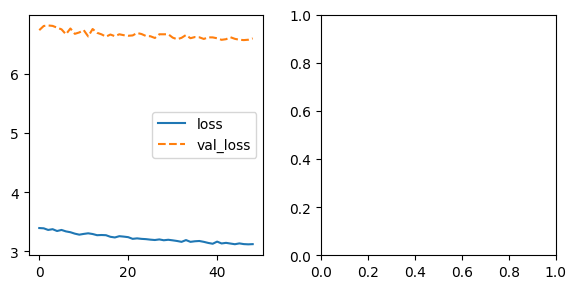

In [28]:
hist = model_ew.fit(train_ew,
                    val_ds=val_ew,
                    epochs=50,
                    verbose=1,
                    plot_hist=True,
                    early_stopping=15,
                    target_metric='val_loss',
                    save_best_only=True,
                    callbacks=[])

In [41]:
model_ns.model.save('submission/models/NS_localizer_cnn.hdf5')
pickle.dump(ds_gen_ns.scaler, open('submission/models/NS_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_ns.save_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:
print(model_ns.model.optimizer.learning_rate)

In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [5]:
model_ns = tf.keras.models.load_model("/home/david/Code/splid-challenge/wandb/run-20240218_035447-mbp964ar/files\model_mbp964ar.hdf5" )


2024-02-18 14:18:18.977907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 14:18:19.002286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 14:18:19.002359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 14:18:19.004111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 14:18:19.004188: I external/local_xla/xla/stream_executor

In [16]:
model_ns = tf.keras.models.load_model("submission/models/NS_localizer_cnn.hdf5")

2024-02-18 22:18:46.618223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 22:18:46.645329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 22:18:46.645397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 22:18:46.647285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-18 22:18:46.647358: I external/local_xla/xla/stream_executor

In [34]:
object_limit = None
directions = ['NS']

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ns,
                                model=model_ns,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=directions,
                                object_limit=object_limit,
                                only_ew_sk=False,
                                ds_batch_size=1024,
                                prediction_batches=10,
                                verbose=1)

81/81 [==============================] - 1s 7ms/step


In [36]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=directions,
                                            threshold=60.0,
                                            add_initial_node=True,
                                            clean_consecutives=True,
                                            deepcopy=False)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ns.val_keys))[:object_limit],
                                                 dirs=directions,
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

# EW after 180 epochs:
# 50: TP: 617 FP: 66 FN: 34
# 55: TP: 614 FP: 46 FN: 37
# 60: TP: 613 FP: 37 FN: 38
# 65: TP: 608 FP: 24 FN: 43
# 70: TP: 606 FP: 20 FN: 45

# NS after 60 epochs:
# 50: TP: 352 FP: 144 FN: 77
# 55: TP: 348 FP: 102 FN: 81
# 60: TP: 344 FP: 76 FN: 85
# 65: TP: 341 FP: 64 FN: 88
# 70: TP: 335 FP: 58 FN: 94


# Combined after 100 epochs
# 50: TP: 923 FP: 364 FN: 157
# 55: TP: 917 FP: 281 FN: 163
# 60: TP: 911 FP: 196 FN: 169
# 65: TP: 902 FP: 135 FN: 178
# 70: TP: 894 FP: 100 FN: 186


Evaluator ignoring classifications
Precision: 0.86
Recall: 0.87
F2: 0.87
RMSE: 0.9851
TP: 373 FP: 63 FN: 56


In [8]:
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
for node in ['ID', 'AD', 'IK']:
    tp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'TP')])
    #fp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FP')])
    fn = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FN')])
    print(f"{node}: TP: {tp} FN: {fn}")

#EW:
# ID: TP: 114 FN: 42
# AD: TP: 264 FN: 13
# IK: TP: 203 FN: 15

#NS:  
# ID: TP: 112 FN: 104
# AD: TP: 0 FN: 0
# IK: TP: 185 FN: 28


ID: TP: 130 FN: 26
AD: TP: 264 FN: 13
IK: TP: 203 FN: 15


26/26 - 0s - 303ms/epoch - 12ms/step
(19,)


/home/david/Code/splid-challenge/base/localizer.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[timeindex-20:timeindex+20, 'keep'] = True
/home/david/Code/splid-challenge/base/localizer.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


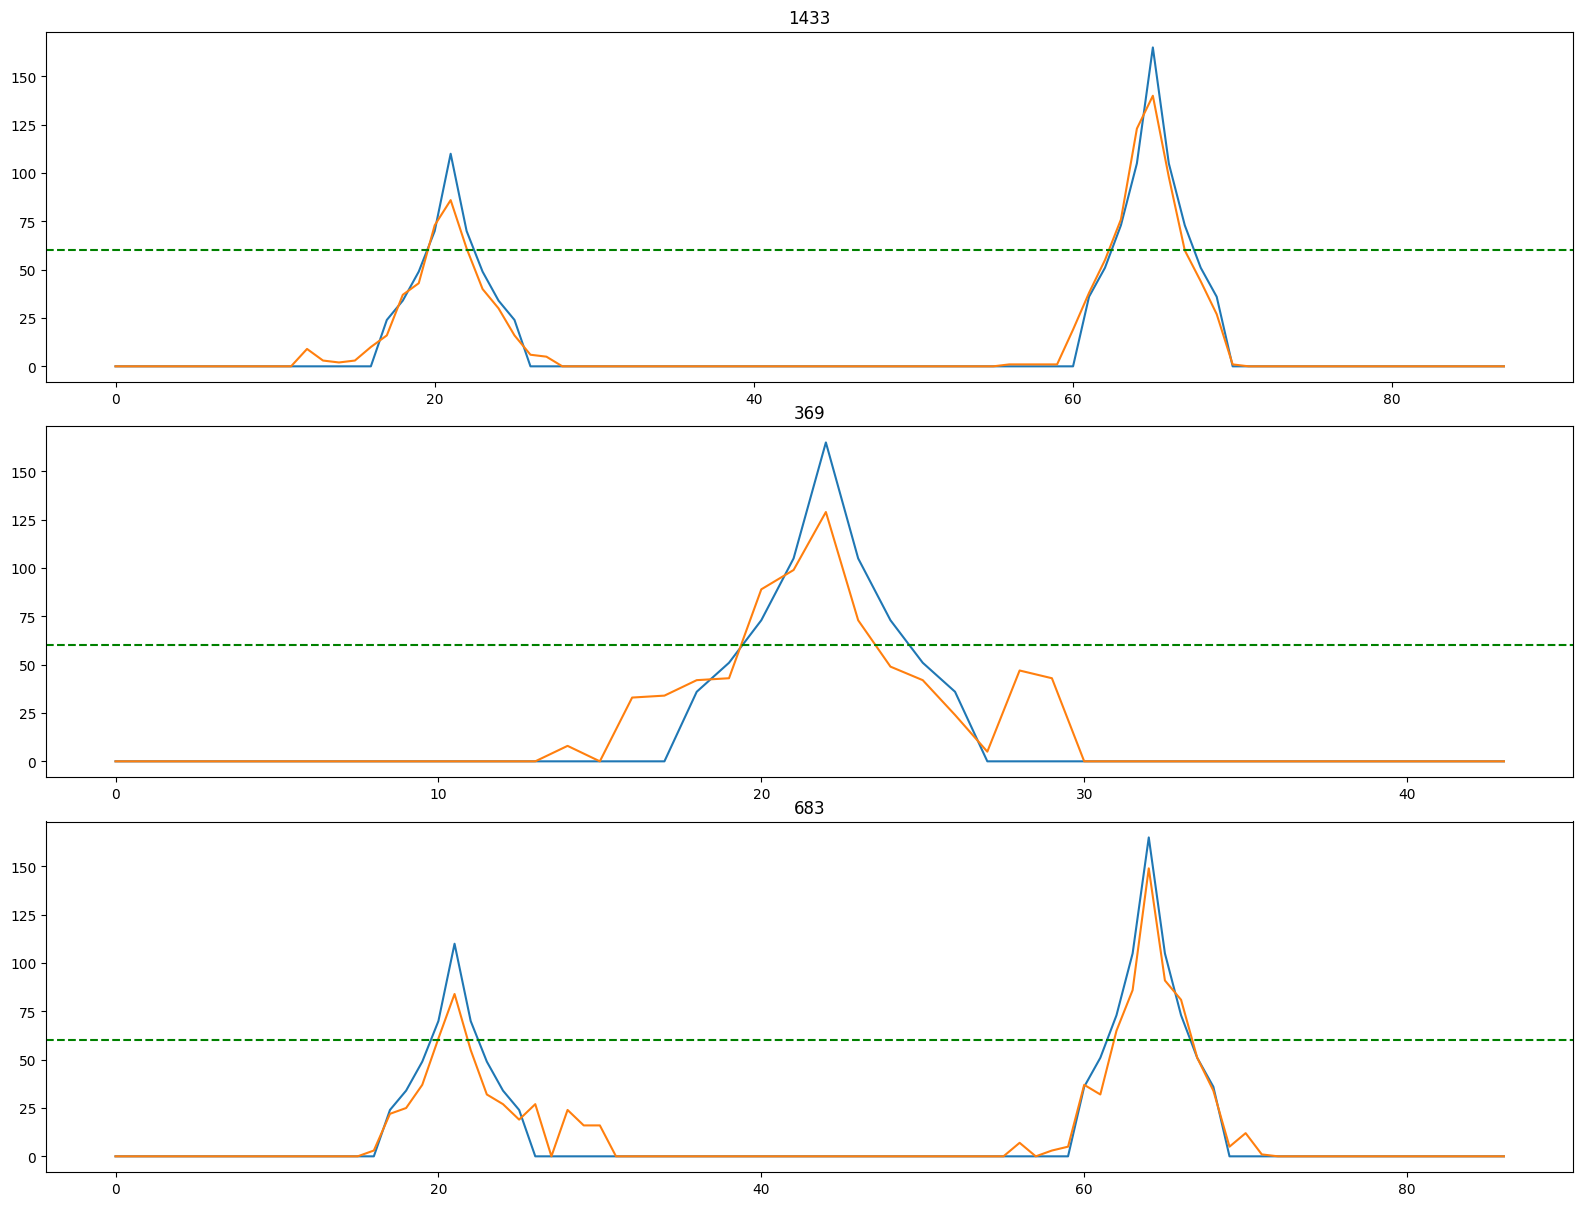

In [40]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ns,
                                model=model_ns,
                                label_features=['NS_Node_Location_nb'],
                                object_ids=['683','369','1433'],#ds_gen_ns.val_keys[100:150],
                                threshold=60.0,
                                zoom=True)